# Anime LDA Topic Similarity Model

### Read data import

In [1]:
import mysql.connector as my_sql
from dotenv import load_dotenv
import os
import pandas as pd

### Read data

In [2]:
load_dotenv()

mydb = my_sql.connect(
    host=os.getenv('DATABASE_HOST'),
    user=os.getenv('DATABASE_USER'),
    password=os.getenv('DATABASE_PASSWORD'),
    database=os.getenv('DATABASE_NAME')
)

In [3]:
print(mydb)

In [4]:
mycursor = mydb.cursor()

In [5]:
mycursor.execute('SELECT Title, Synopsis FROM MAL_Anime_Details')

df = pd.DataFrame(mycursor.fetchall(), columns=[
    'Title',
    'Synopsis'
])

df.head()

,Title,Synopsis
0,Cowboy Bebop,"In the year 2071, humanity has colonized sever..."
1,Cowboy Bebop: Tengoku no Tobira,"Another day, another bounty—such is the life o..."
2,Trigun,"Vash the Stampede is the man with a $$60,000,0..."
3,Witch Hunter Robin,Witches are individuals with special powers li...
4,Bouken Ou Beet,It is the dark century and the people are suff...


In [6]:
mycursor.close()

True

### Clean data imports

In [7]:
import re

### Clean data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6888 entries, 0 to 6887
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     6888 non-null   object
 1   Synopsis  6888 non-null   object
dtypes: object(2)
memory usage: 107.8+ KB


In [9]:
# Check for duplicate titles
duplicated_title = df[df['Title'].duplicated()]
print("There are " + str(len(duplicated_title)) + " duplicate titles")

There are 0 duplicate titles


In [10]:
def filter_sources(text):
    """
    
    """
    
    new_text = re.sub('\(Source:.*\)', '', text, flags=re.IGNORECASE)
    
#     for src in srcs:
#         text = text.replace(src, '')
        
    new_text = re.sub('\[(Writt|from|Source).*\]', '', new_text, flags=re.IGNORECASE)
    
#     for src in srcs_2:
#         text = text.replace(src, '')
    
    return new_text.strip()

In [11]:
filtered_srcs_df = df.copy()
filtered_srcs_df['Synopsis'] = filtered_srcs_df['Synopsis'].apply(filter_sources)

In [12]:
def filter_notes(text):
    """
    
    """
    
    new_text = re.sub('Note:', '', text, flags=re.IGNORECASE)
    
    
    return new_text.strip()

In [13]:
filtered_notes_df = filtered_srcs_df.copy()
filtered_notes_df['Synopsis'] = filtered_notes_df['Synopsis'].apply(filter_notes)

In [14]:
filtered_notes_df.shape

(6888, 2)

In [15]:
# Dropping rows with no real synopsis
filtered_synopsis_df = filtered_notes_df.copy()
filtered_synopsis_df = filtered_synopsis_df[filtered_synopsis_df['Synopsis'] != 'No synopsis has been added for this series yet. Click here to update this information.']
filtered_synopsis_df = filtered_synopsis_df[filtered_synopsis_df['Synopsis'] != 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here.']
filtered_synopsis_df.shape

(6774, 2)

In [16]:
# Dropping rows with non-useful synopsis
filtered_synopsis_df = filtered_synopsis_df[filtered_synopsis_df['Synopsis'] != 'Movie based on the 1985 TV anime with an original plot.']
filtered_synopsis_df = filtered_synopsis_df[filtered_synopsis_df['Synopsis'] != 'A mix of animation and live-action.']
filtered_synopsis_df = filtered_synopsis_df[filtered_synopsis_df['Synopsis'] != 'Short specials added to DVDs and Blu-rays.']
filtered_synopsis_df = filtered_synopsis_df[filtered_synopsis_df['Synopsis'] != 'Special episodes added to DVDs and Blu-rays.']
filtered_synopsis_df.shape

(6764, 2)

In [17]:
def filter_japanese_characters(text):
    """
    
    """
    
    new_text = re.sub('/[\u3000-\u303F]|[\u3040-\u309F]|[\u30A0-\u30FF]|[\uFF00-\uFFEF]|[\u4E00-\u9FAF]|[\u2605-\u2606]|[\u2190-\u2195]|\u203B/g', '', text)
        
    return new_text

In [18]:
filtered_synopsis_df["Synopsis"] = filtered_synopsis_df["Synopsis"].apply(filter_japanese_characters)

In [19]:
def filter_escaped_characters(text):
    """
    NOT WORKING
    """
    
    new_text = text.replace('\\','')
        
    return new_text

In [20]:
filtered_synopsis_df["Synopsis"] = filtered_synopsis_df["Synopsis"].apply(filter_escaped_characters)

### Process data imports

In [21]:
from gensim.models import Phrases
import spacy
from spacy.lang.en import English
import string
import unidecode

### Process data

In [22]:
nlp = spacy.load("en_core_web_lg")

In [23]:
spacy_df = filtered_synopsis_df.copy()

In [24]:
def remove_people(text):
    """
    
    """
    
    text_nlp = nlp(text)
    
    for ent in text_nlp.ents:
        if(ent.label_ == 'PERSON'):
            text = text.replace(ent.text, '')
            
    return text

In [25]:
# Remove numbers
def filter_numbers(text):
    return ''.join(c for c in text if not c.isdigit())

In [26]:
def clean_text(text):
    """
    Cleans text, keeping only alphanumeric characters
        
    Parameters
    ----------
    token: str
        Word being processed

    Returns
    -------
    str:
        Cleaned string
    """
    
    cleaned_text = str(text).translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    cleaned_text = re.sub("[\W]+", " ", cleaned_text)
    
    return cleaned_text

In [27]:
def spacy_clean_text(text):
    """
    Lemmatizes text using spaCy
        
    Parameters
    ----------
    text: str
        Text being processed

    Returns
    -------
    str:
        Lemmatized text
    """
    
    if text == '':
        return text
    
    # Remove people
    cleaned_text = remove_people(text)
    
    # Clean  
    cleaned_text = clean_text(cleaned_text)
    
    # Tokenize
    tokens = nlp(cleaned_text.lower())
    
    remove_list = [
    'episode',
    'series',
    'short',
    'anime',
    'story',
    'film',
    'feature',
    'character',
    'special',
    'movie',
    'animation',
    'original',
    'release',
    'manga',
    'ova',
    'scene',
    'animate'
    ]
    
    # Lemmatize
    lemmatized_text = ' '.join([token.lemma_.strip() for token in tokens if not token.is_stop and not token.is_punct and (token.pos_ == 'NOUN' or token.pos_ == 'ADJ' or token.pos_ == 'VERB' or token.pos_ == 'ADV') and token.lemma_.strip() not in remove_list])
    
    # Remove numbers
    no_numbers_text = filter_numbers(lemmatized_text)
    
    # Remove short words (<= 2)
    removed_singles = [x for x in no_numbers_text.split() if len(x.strip()) > 2]
    
    # Remove numbers
    full = " ".join(removed_singles)
    
    return unidecode.unidecode(full)

In [28]:
spacy_df['Corpus'] = spacy_df['Synopsis']
spacy_df = spacy_df[["Title", "Corpus"]]

spacy_df["Corpus"] = spacy_df["Corpus"].apply(spacy_clean_text).copy()

In [29]:
english_nlp = English()
english_nlp.add_pipe(english_nlp.create_pipe('sentencizer'))

def split_doc_to_sentence(doc):
    split_doc = english_nlp(doc)
    return [sent.string.strip() for sent in split_doc.sents]

In [30]:
list_of_list = list(map(lambda x: split_doc_to_sentence(x), spacy_df['Corpus'].tolist()))
flatten = lambda t: [item for sublist in t for item in sublist]
unigram_sentences = flatten(list_of_list)
unigram_sentences = [x.split() for x in unigram_sentences]

In [59]:
bigram_sentences = []
trigram_sentences = []

# to create the bigrams
bigram_model = Phrases(unigram_sentences)

# apply the trained model to a sentence
for unigram_sentence in unigram_sentences:                
    bigram_sentence = u' '.join(bigram_model[unigram_sentence])
    bigram_sentences.append(bigram_sentence)

bigram_sentences = [x.split() for x in bigram_sentences]
# get a trigram model out of the bigram
trigram_model = Phrases(bigram_sentences)

for bigram_sentence in bigram_sentences:
    trigram_sentence = u' '.join(trigram_model[bigram_sentence])
    trigram_sentences.append(trigram_sentence)

In [60]:
for i, synopsis in enumerate(trigram_sentences, start=0):
    spacy_df['Corpus'][i] = synopsis

In [61]:
spacy_df.shape

(6315, 2)

In [63]:
spacy_df = spacy_df[spacy_df['Corpus'].map(len) >= 25]

In [64]:
spacy_df.shape

(6315, 2)

### Topic Modeling

In [65]:
from collections import defaultdict
from gensim import corpora, models

In [66]:
texts = [
    [token for token in text.split()]
    for text in spacy_df['Corpus']
]

dictionary = corpora.Dictionary(texts)
no_below = int(len(texts) * 0.01)
dictionary.filter_extremes(no_below=no_below, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]

In [67]:
mallet_path = os.getenv('MALLET_PATH')

def get_coherence_scores(dictionary, corpus, texts, start, stop, step):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, stop, step):
        model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=1000, optimize_interval=10)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [68]:
model_list, coherence_values = get_coherence_scores(dictionary=dictionary, corpus=corpus, texts=texts, start=4, stop=24, step=1)

### Visual analysis imports

In [69]:
import matplotlib.pyplot as plt

### Visual analysis

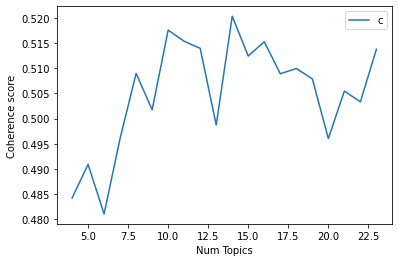

In [70]:
start=4; stop=24; step=1;
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
for i, (m, cv) in enumerate(zip(x, coherence_values)):
    print("Index", i, ":", "Num Topics =", m, "has Coherence Value of", round(cv, 4))

Index 0 : Num Topics = 4 has Coherence Value of 0.4842
Index 1 : Num Topics = 5 has Coherence Value of 0.4909
Index 2 : Num Topics = 6 has Coherence Value of 0.4811
Index 3 : Num Topics = 7 has Coherence Value of 0.4961
Index 4 : Num Topics = 8 has Coherence Value of 0.509
Index 5 : Num Topics = 9 has Coherence Value of 0.5018
Index 6 : Num Topics = 10 has Coherence Value of 0.5176
Index 7 : Num Topics = 11 has Coherence Value of 0.5154
Index 8 : Num Topics = 12 has Coherence Value of 0.514
Index 9 : Num Topics = 13 has Coherence Value of 0.4987
Index 10 : Num Topics = 14 has Coherence Value of 0.5203
Index 11 : Num Topics = 15 has Coherence Value of 0.5124
Index 12 : Num Topics = 16 has Coherence Value of 0.5153
Index 13 : Num Topics = 17 has Coherence Value of 0.5089
Index 14 : Num Topics = 18 has Coherence Value of 0.51
Index 15 : Num Topics = 19 has Coherence Value of 0.5079
Index 16 : Num Topics = 20 has Coherence Value of 0.496
Index 17 : Num Topics = 21 has Coherence Value of 0.

In [76]:
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.037*"war" + 0.031*"world" + 0.021*"year" + 0.019*"force" + 0.015*"fight" + 0.014*"weapon" + 0.014*"battle" + 0.013*"life" + 0.013*"military" + 0.012*"country"'), (1, '0.039*"live" + 0.032*"life" + 0.026*"town" + 0.025*"friend" + 0.021*"human" + 0.021*"cat" + 0.020*"people" + 0.019*"world" + 0.018*"day" + 0.016*"find"'), (2, '0.092*"school" + 0.056*"girl" + 0.052*"student" + 0.031*"club" + 0.028*"class" + 0.023*"high_school" + 0.022*"teacher" + 0.022*"boy" + 0.022*"day" + 0.017*"member"'), (3, '0.061*"earth" + 0.043*"planet" + 0.031*"robot" + 0.025*"space" + 0.023*"alien" + 0.015*"pilot" + 0.014*"attack" + 0.014*"fight" + 0.014*"destroy" + 0.013*"call"'), (4, '0.059*"demon" + 0.038*"monster" + 0.036*"power" + 0.035*"world" + 0.028*"human" + 0.024*"evil" + 0.016*"fight" + 0.014*"dark" + 0.014*"god" + 0.013*"save"'), (5, '0.062*"father" + 0.057*"family" + 0.051*"mother" + 0.026*"live" + 0.024*"child" + 0.023*"life" + 0.019*"daughter" + 0.018*"day" + 0.014*"son" + 0.014*"sister"'),

In [77]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [78]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [79]:
# Show
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.3644,"city, find, mysterious, death, world, man, tim...","[year, humanity, colonize_planet, moon, solar_..."
1,1,13.0,0.6282,"city, find, mysterious, death, world, man, tim...","[day, bounty, life, unlucky, crew, bebop, rout..."
2,2,13.0,0.6132,"city, find, mysterious, death, world, man, tim...","[man, bounty, head, reason, merciless, villain..."
3,3,11.0,0.4396,"princess, world, magic, magical, kingdom, girl...","[witch, individual, power, mind, control, year..."
4,4,6.0,0.8041,"fight, power, world, warrior, evil, defeat, ba...","[dark, century, people, suffer, rule, vandel, ..."
5,5,7.0,0.5283,"team, game, play, world, player, win, race, ma...","[shy, kid, start, high_school, try, survive, c..."
6,6,10.0,0.8714,"girl, love, friend, day, life, school, find, t...","[sophomore, art, college, share, cheap, apartm..."
7,7,1.0,0.3417,"live, life, town, friend, human, cat, people, ...","[live, shadow, successful, brother, life, prof..."
8,8,7.0,0.7632,"team, game, play, world, player, win, race, ma...","[finally, join, create, project, goal, twofold..."
9,9,13.0,0.6870,"city, find, mysterious, death, world, man, tim...","[elite, neurosurgeon, recently, engage, hospit..."


In [80]:
spacy_df['Corpus'][14]

'word love change nature bittersweet trial high_school romance second_year quest confess_feeling boy like delinquent sizable reputation similar situation properly convey feeling love school friend rivalry hobby find high_school romance walk park especially misunderstanding complicate plight school rumble high octane romantic_comedy relatable situation try win_heart desire'